##**Network pruning and finetuning**  
In this tutorial global network pruning and finetuning is explored using pruning module in pytorch

-- The convolution and linear module wrapper has been adapted from :
https://github.com/wanglouis49/pytorch-weights_pruning

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import PIL
import torch.nn.utils.prune as prune
from torch.autograd import Variable

%matplotlib inline

In this assignment CIFAR10 dataset has been used

In [2]:
trainset = datasets.CIFAR10(root = './Data',train = True,download= True,transform= transforms.ToTensor())
testset = datasets.CIFAR10(root = './Data',train = False,download= True,transform= transforms.ToTensor())


Extracting ./Data/cifar-10-python.tar.gz to ./Data
Files already downloaded and verified


In [3]:
len(trainset) 

50000

In [4]:
len(testset)

10000

Load and preprocess data

In [5]:
trainloader = DataLoader(trainset,batch_size=256,shuffle=True,num_workers=2)
testloader = DataLoader(testset,batch_size=256,shuffle=False,num_workers=2)

In [6]:
dataiter = iter(trainloader)
data = next(dataiter)

In [7]:
img = data[0][0].numpy()

(-0.5, 31.5, 31.5, -0.5)

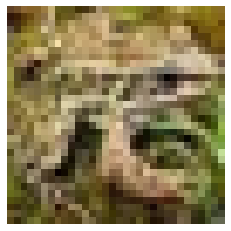

In [8]:
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.axis('off')

In [9]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Create the base Lenet model:

In [10]:
class model(nn.Module):
  def __init__(self):
    super(model,self).__init__()
    self.conv1 = nn.Conv2d(3,6,3)
    self.pool1 = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6,16,5)
    self.pool2 = nn.MaxPool2d(2,2)
    self.fc1 = nn.Linear(16*5*5,120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)

  def forward(self,x):
    x = self.pool1(F.relu(self.conv1(x)))
    x = self.pool2(F.relu(self.conv2(x)))
    x = torch.flatten(x,1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [11]:
net = model()

In [12]:
for child in net.children():
  print(child)

Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Linear(in_features=400, out_features=120, bias=True)
Linear(in_features=120, out_features=84, bias=True)
Linear(in_features=84, out_features=10, bias=True)


In [13]:
# Print the named parameters

print('parameter start')
for name, parameter in net.named_parameters():
    print(name)
    print(type(parameter))
    print(parameter.is_leaf)
print('parameter end')


parameter start
conv1.weight
<class 'torch.nn.parameter.Parameter'>
True
conv1.bias
<class 'torch.nn.parameter.Parameter'>
True
conv2.weight
<class 'torch.nn.parameter.Parameter'>
True
conv2.bias
<class 'torch.nn.parameter.Parameter'>
True
fc1.weight
<class 'torch.nn.parameter.Parameter'>
True
fc1.bias
<class 'torch.nn.parameter.Parameter'>
True
fc2.weight
<class 'torch.nn.parameter.Parameter'>
True
fc2.bias
<class 'torch.nn.parameter.Parameter'>
True
fc3.weight
<class 'torch.nn.parameter.Parameter'>
True
fc3.bias
<class 'torch.nn.parameter.Parameter'>
True
parameter end


In [14]:
#print the named modules

print('parameter start')
for name, module in net.named_modules():
    print(name)
    print(type(module))
print('parameter end')

parameter start

<class '__main__.model'>
conv1
<class 'torch.nn.modules.conv.Conv2d'>
pool1
<class 'torch.nn.modules.pooling.MaxPool2d'>
conv2
<class 'torch.nn.modules.conv.Conv2d'>
pool2
<class 'torch.nn.modules.pooling.MaxPool2d'>
fc1
<class 'torch.nn.modules.linear.Linear'>
fc2
<class 'torch.nn.modules.linear.Linear'>
fc3
<class 'torch.nn.modules.linear.Linear'>
parameter end


In [15]:
#Handle gpu

use_gpu = torch.cuda.is_available()
if use_gpu:
 net = net.cuda()

In [16]:
print(net)

model(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [17]:
net.parameters

<bound method Module.parameters of model(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)>

Train the model with CrossEntropyLoss

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
num_epochs = 30
train_loss = []
train_acc = []

for i in range(num_epochs):
  running_loss = 0.
  running_acc = 0.
  for idx,data in enumerate(trainloader):
    inputs,labels = data
    if use_gpu:
      inputs,labels = inputs.cuda(),labels.cuda()
    optimizer.zero_grad()

    output = net(inputs)
    loss = criterion(output,labels)
    preds = torch.argmax(output,dim = 1)

    running_loss += loss.item()
    running_acc += torch.sum(preds == labels)

    loss.backward()
    optimizer.step()

  epoch_loss = running_loss/(i+1)
  epoch_acc = running_acc.item()/50000

  train_loss.append(epoch_loss)
  train_acc.append(epoch_acc)
  
  print('Epoch {:.0f}/{:.0f} : Training loss: {:.4f} | Training Accuracy: {:.4f}'.format(i+1,num_epochs,epoch_loss,epoch_acc*100))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1/30 : Training loss: 379.9535 | Training Accuracy: 27.8460
Epoch 2/30 : Training loss: 156.6045 | Training Accuracy: 40.8940
Epoch 3/30 : Training loss: 97.4413 | Training Accuracy: 45.3560
Epoch 4/30 : Training loss: 69.9271 | Training Accuracy: 47.7860
Epoch 5/30 : Training loss: 54.4308 | Training Accuracy: 49.8060
Epoch 6/30 : Training loss: 43.8539 | Training Accuracy: 51.3600
Epoch 7/30 : Training loss: 36.6334 | Training Accuracy: 52.8720
Epoch 8/30 : Training loss: 31.3891 | Training Accuracy: 54.0360
Epoch 9/30 : Training loss: 27.2110 | Training Accuracy: 55.0620
Epoch 10/30 : Training loss: 24.1378 | Training Accuracy: 55.9420
Epoch 11/30 : Training loss: 21.5716 | Training Accuracy: 56.5960
Epoch 12/30 : Training loss: 19.3432 | Training Accuracy: 57.6820
Epoch 13/30 : Training loss: 17.5683 | Training Accuracy: 58.3140
Epoch 14/30 : Training loss: 15.9839 | Training Accuracy: 59.2760
Epoch 15/30 : Training loss: 14.6981 | Training Accuracy: 60.0240
Epoch 16/30 : Tra

Find the pretrained network validation accuracy. This validation accuracy will be later used to match the accuracy of finetuned and pruned network

In [19]:
net.eval()

correct_pred = 0
with torch.no_grad():
  for data in testloader:
    inputs,labels = data
    if use_gpu:
        inputs, labels = inputs.cuda(),labels.cuda()
    # Feedforward train data batch through model
    output = net(inputs) 
    # Predicted class is the one with maximum probability
    preds = torch.argmax(output,dim=1)
    correct_pred += torch.sum(preds==labels)

test_accuracy = correct_pred.item()/10000.0
print('Testing accuracy = ',test_accuracy*100)

Testing accuracy =  62.09


Save the pretrained model

In [20]:
#save the model:
PATH = '/content/drive/MyDrive/Lenet_pretrained/state_dict.pt'
torch.save(net.state_dict(),PATH)

Create the Linear and convolutional module wrapper.

-- these wrappers are built on nn.Linear and nn.Conv2D modules to handle masks during forward propagation

--Multiplying the mask is a differentiable operation and the backward pass is handed by automatic differentiation (no explicit coding needed).

In [37]:
class LinearMasked(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super(LinearMasked, self).__init__(in_features, out_features, bias)
        self.mask_flag = False

    def set_mask(self, mask):
        self.mask = Variable(mask, requires_grad=False, volatile=False)
        self.weight.data = self.weight.data * self.mask.data
        self.mask_flag = True

    def get_mask(self):
        print(self.mask_flag)
        return self.mask

    def forward(self, x):
        if self.mask_flag:
            weight = self.weight * self.mask.cuda()
            return F.linear(x, weight, self.bias)
        else:
            return F.linear(x, self.weight, self.bias)

In [38]:
class Conv2dMasked(nn.Conv2d):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride=1,
        padding=0,
        dilation=1,
        groups=1,
        bias=True,
    ):
        super(Conv2dMasked, self).__init__(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            dilation,
            groups,
            bias,
        )
        self.mask_flag = False

    def set_mask(self, mask):
        self.mask = Variable(mask, requires_grad=False, volatile=False)
        self.weight.data = self.weight.data * self.mask.data
        self.mask_flag = True

    def get_mask(self):
        print(self.mask_flag)
        return self.mask

    def forward(self, x):
        if self.mask_flag:
            weight = self.weight * self.mask.cuda()
            return F.conv2d(
                x,
                weight,
                self.bias,
                self.stride,
                self.padding,
                self.dilation,
                self.groups,
            )
        else:
            return F.conv2d(
                x,
                self.weight,
                self.bias,
                self.stride,
                self.padding,
                self.dilation,
                self.groups,
            )

In [39]:
##Updated Lenetmodel

class Lenetmodel(nn.Module):
  def __init__(self):
    super(Lenetmodel,self).__init__()
    self.conv1 = Conv2dMasked(3,6,kernel_size=3)
    self.pool1 = nn.MaxPool2d(2,2)
    self.conv2 = Conv2dMasked(6,16,kernel_size=5)
    self.pool2 = nn.MaxPool2d(2,2)
    self.fc1 = LinearMasked(16*5*5,120)
    self.fc2 = LinearMasked(120,84)
    self.fc3 = LinearMasked(84,10)

  def forward(self,x):
    x = self.pool1(F.relu(self.conv1(x)))
    x = self.pool2(F.relu(self.conv2(x)))
    x = torch.flatten(x,1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

Load back the pretrained model to be pruned and finetuned

In [54]:
new_net = Lenetmodel()

In [55]:
new_net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [56]:
new_net

Lenetmodel(
  (conv1): Conv2dMasked(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2dMasked(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): LinearMasked(in_features=400, out_features=120, bias=True)
  (fc2): LinearMasked(in_features=120, out_features=84, bias=True)
  (fc3): LinearMasked(in_features=84, out_features=10, bias=True)
)

In [57]:
# define parameters to prune

parameters_to_prune = (
    (new_net.conv1, 'weight'),
    (new_net.conv2, 'weight'),
    (new_net.fc1, 'weight'),
    (new_net.fc2, 'weight'),
    (new_net.fc3, 'weight'),
)

prune the network using prune module. Here we have used 60% pruning

In [58]:
prune.global_unstructured(parameters_to_prune,pruning_method=prune.L1Unstructured,amount=0.6)

In [59]:
for param,name in parameters_to_prune:
  mask = param.weight_mask
  param.set_mask(mask)

check the original weights and the weight masks

In [60]:
new_net.conv1.weight_orig

Parameter containing:
tensor([[[[ 0.0880, -0.0083,  0.3434],
          [ 0.0369, -0.1505,  0.0183],
          [-0.1472, -0.1712, -0.3368]],

         [[ 0.2201,  0.0955,  0.0852],
          [ 0.0756, -0.1340,  0.1160],
          [-0.1664,  0.1794, -0.0630]],

         [[-0.1087, -0.0063,  0.0418],
          [-0.0057,  0.0888, -0.1678],
          [ 0.1416, -0.0938, -0.1684]]],


        [[[-0.0488, -0.2384, -0.2116],
          [ 0.0089, -0.0187, -0.0315],
          [ 0.0969, -0.0260,  0.0165]],

         [[-0.0243, -0.0329, -0.0947],
          [-0.0317,  0.1372, -0.1602],
          [ 0.1535,  0.0545, -0.1972]],

         [[ 0.2337,  0.0006, -0.2348],
          [ 0.2871,  0.2595, -0.1768],
          [ 0.2017,  0.1390,  0.1679]]],


        [[[-0.0699,  0.1371,  0.1545],
          [ 0.1317,  0.0923, -0.0092],
          [ 0.2731, -0.0688, -0.1003]],

         [[ 0.0412,  0.2201,  0.1068],
          [ 0.1569, -0.0133, -0.1563],
          [-0.1501,  0.0474,  0.0055]],

         [[ 0.0371, -0

In [61]:
for name,param in new_net.named_parameters():
  print(name)

conv1.bias
conv1.weight_orig
conv2.bias
conv2.weight_orig
fc1.bias
fc1.weight_orig
fc2.bias
fc2.weight_orig
fc3.bias
fc3.weight_orig


set the pruned weights to zero

In [62]:
for module,name in parameters_to_prune:
  prune.remove(module,name)

In [63]:
new_net.conv1.weight

Parameter containing:
tensor([[[[ 0.0880, -0.0000,  0.3434],
          [ 0.0000, -0.1505,  0.0000],
          [-0.1472, -0.1712, -0.3368]],

         [[ 0.2201,  0.0955,  0.0852],
          [ 0.0756, -0.1340,  0.1160],
          [-0.1664,  0.1794, -0.0000]],

         [[-0.1087, -0.0000,  0.0000],
          [-0.0000,  0.0888, -0.1678],
          [ 0.1416, -0.0938, -0.1684]]],


        [[[-0.0000, -0.2384, -0.2116],
          [ 0.0000, -0.0000, -0.0000],
          [ 0.0969, -0.0000,  0.0000]],

         [[-0.0000, -0.0000, -0.0947],
          [-0.0000,  0.1372, -0.1602],
          [ 0.1535,  0.0000, -0.1972]],

         [[ 0.2337,  0.0000, -0.2348],
          [ 0.2871,  0.2595, -0.1768],
          [ 0.2017,  0.1390,  0.1679]]],


        [[[-0.0699,  0.1371,  0.1545],
          [ 0.1317,  0.0923, -0.0000],
          [ 0.2731, -0.0688, -0.1003]],

         [[ 0.0000,  0.2201,  0.1068],
          [ 0.1569, -0.0000, -0.1563],
          [-0.1501,  0.0000,  0.0000]],

         [[ 0.0000, -0

In [64]:
for name,param in new_net.named_parameters():
  print(name)

conv1.bias
conv1.weight
conv2.bias
conv2.weight
fc1.bias
fc1.weight
fc2.bias
fc2.weight
fc3.bias
fc3.weight


Check accuracy of the pruned model

In [66]:
use_gpu = torch.cuda.is_available()
if use_gpu:
  new_net = new_net.cuda()

new_net.eval()

correct_pred = 0
with torch.no_grad():
  for data in testloader:
    inputs,labels = data
    if use_gpu:
        inputs, labels = inputs.cuda(),labels.cuda()
    # Feedforward train data batch through model
    output = new_net(inputs) 
    # Predicted class is the one with maximum probability
    preds = torch.argmax(output,dim=1)
    correct_pred += torch.sum(preds==labels)

test_accuracy = correct_pred.item()/10000.0
print('Testing accuracy = ',test_accuracy*100)

Testing accuracy =  41.55


Finetune the pruned model 

In [67]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(new_net.parameters())
num_epochs = 20
train_loss = []
train_acc = []

new_net.train()
for i in range(num_epochs):
  running_loss = 0.
  running_acc = 0.
  for idx,data in enumerate(trainloader):
    inputs,labels = data
    if use_gpu:
      inputs,labels = inputs.cuda(),labels.cuda()
    optimizer.zero_grad()

    output = new_net(inputs)
    loss = criterion(output,labels)
    preds = torch.argmax(output,dim = 1)

    running_loss += loss.item()
    running_acc += torch.sum(preds == labels)

    loss.backward()
    optimizer.step()

  epoch_loss = running_loss/(i+1)
  epoch_acc = running_acc.item()/50000

  train_loss.append(epoch_loss)
  train_acc.append(epoch_acc)
  
  print('Epoch {:.0f}/{:.0f} : Training loss: {:.4f} | Training Accuracy: {:.4f}'.format(i+1,num_epochs,epoch_loss,epoch_acc*100))

Epoch 1/20 : Training loss: 185.9354 | Training Accuracy: 66.4600
Epoch 2/20 : Training loss: 89.0182 | Training Accuracy: 67.9200
Epoch 3/20 : Training loss: 58.7797 | Training Accuracy: 68.2160
Epoch 4/20 : Training loss: 43.6704 | Training Accuracy: 68.5100
Epoch 5/20 : Training loss: 34.4369 | Training Accuracy: 68.9420
Epoch 6/20 : Training loss: 28.5136 | Training Accuracy: 69.2000
Epoch 7/20 : Training loss: 24.3507 | Training Accuracy: 69.1840
Epoch 8/20 : Training loss: 21.0297 | Training Accuracy: 69.4880
Epoch 9/20 : Training loss: 18.6446 | Training Accuracy: 69.5720
Epoch 10/20 : Training loss: 16.6749 | Training Accuracy: 69.8780
Epoch 11/20 : Training loss: 15.0318 | Training Accuracy: 70.1560
Epoch 12/20 : Training loss: 13.7437 | Training Accuracy: 70.2360
Epoch 13/20 : Training loss: 12.5588 | Training Accuracy: 70.5560
Epoch 14/20 : Training loss: 11.6366 | Training Accuracy: 70.7700
Epoch 15/20 : Training loss: 10.7262 | Training Accuracy: 70.8900
Epoch 16/20 : Trai

Check the masked weights' value - they should not change

In [68]:
new_net.conv1.weight

Parameter containing:
tensor([[[[ 0.1046, -0.0000,  0.3919],
          [ 0.0000, -0.1533,  0.0000],
          [-0.1415, -0.1856, -0.4004]],

         [[ 0.2189,  0.0941,  0.1211],
          [ 0.0927, -0.1468,  0.1252],
          [-0.1534,  0.1764, -0.0000]],

         [[-0.1140, -0.0000,  0.0000],
          [-0.0000,  0.0739, -0.1497],
          [ 0.1504, -0.0952, -0.2026]]],


        [[[-0.0000, -0.3074, -0.2558],
          [ 0.0000, -0.0000, -0.0000],
          [ 0.0370, -0.0000,  0.0000]],

         [[-0.0000, -0.0000, -0.1230],
          [-0.0000,  0.1603, -0.1852],
          [ 0.1906,  0.0000, -0.1937]],

         [[ 0.2385,  0.0000, -0.2514],
          [ 0.3108,  0.2844, -0.1960],
          [ 0.2230,  0.1994,  0.1715]]],


        [[[-0.0447,  0.1185,  0.1441],
          [ 0.1620,  0.1045, -0.0000],
          [ 0.3168, -0.0264, -0.1056]],

         [[ 0.0000,  0.2556,  0.1380],
          [ 0.1955, -0.0000, -0.1761],
          [-0.1343,  0.0000,  0.0000]],

         [[ 0.0000, -0

In [69]:
for name,param in new_net.named_parameters():
  print(name) 

conv1.bias
conv1.weight
conv2.bias
conv2.weight
fc1.bias
fc1.weight
fc2.bias
fc2.weight
fc3.bias
fc3.weight


Check the accuracy of the finetuned model and tally with the previous validation accuracy

In [70]:
new_net.eval()

correct_pred = 0
with torch.no_grad():
  for data in testloader:
    inputs,labels = data
    if use_gpu:
        inputs, labels = inputs.cuda(),labels.cuda()
    # Feedforward train data batch through model
    output = new_net(inputs) 
    # Predicted class is the one with maximum probability
    preds = torch.argmax(output,dim=1)
    correct_pred += torch.sum(preds==labels)

test_accuracy = correct_pred.item()/10000.0
print('Testing accuracy = ',test_accuracy*100)

Testing accuracy =  62.239999999999995


print the sparsity of the model

In [71]:
print(
    "Sparsity in conv1.weight: {:.2f}%".format(
        100. * float(torch.sum(new_net.conv1.weight == 0))
        / float(new_net.conv1.weight.nelement())
    )
)
print(
    "Sparsity in conv2.weight: {:.2f}%".format(
        100. * float(torch.sum(new_net.conv2.weight == 0))
        / float(new_net.conv2.weight.nelement())
    )
)
print(
    "Sparsity in fc1.weight: {:.2f}%".format(
        100. * float(torch.sum(new_net.fc1.weight == 0))
        / float(new_net.fc1.weight.nelement())
    )
)
print(
    "Sparsity in fc2.weight: {:.2f}%".format(
        100. * float(torch.sum(new_net.fc2.weight == 0))
        / float(new_net.fc2.weight.nelement())
    )
)
print(
    "Sparsity in fc3.weight: {:.2f}%".format(
        100. * float(torch.sum(new_net.fc3.weight == 0))
        / float(new_net.fc3.weight.nelement())
    )
)
print(
    "Global sparsity: {:.2f}%".format(
        100. * float(
            torch.sum(new_net.conv1.weight == 0)
            + torch.sum(new_net.conv2.weight == 0)
            + torch.sum(new_net.fc1.weight == 0)
            + torch.sum(new_net.fc2.weight == 0)
            + torch.sum(new_net.fc3.weight == 0)
        )
        / float(
            new_net.conv1.weight.nelement()
            + new_net.conv2.weight.nelement()
            + new_net.fc1.weight.nelement()
            + new_net.fc2.weight.nelement()
            + new_net.fc3.weight.nelement()
        )
    )
)

Sparsity in conv1.weight: 33.95%
Sparsity in conv2.weight: 51.50%
Sparsity in fc1.weight: 63.29%
Sparsity in fc2.weight: 49.29%
Sparsity in fc3.weight: 30.00%
Global sparsity: 60.00%


In [72]:
new_net.fc1.weight

Parameter containing:
tensor([[ 0.1568,  0.2164,  0.0000,  ..., -0.1191, -0.1524, -0.1245],
        [ 0.0000, -0.1916, -0.0063,  ...,  0.0000,  0.1524, -0.0000],
        [ 0.2644,  0.2760,  0.3364,  ...,  0.0428, -0.1168, -0.0000],
        ...,
        [ 0.0000, -0.0000,  0.0000,  ..., -0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0000,  0.0000,  0.0000],
        [-0.1012,  0.0000,  0.0000,  ..., -0.0000, -0.0974, -0.1378]],
       device='cuda:0', requires_grad=True)